- python 2.7  
- cv2 3.4

In [12]:
import numpy as np
import cv2
from cv2 import aruco
import pickle
import glob
import math
import os 
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
# %matplotlib nbagg
%matplotlib inline

In [13]:
def save_img(name, img):
    file_name = os.path.join("output/test", name)
    cv2.imwrite(file_name, img)

In [14]:
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_4X4_250)
CHARUCO_BOARD = aruco.CharucoBoard_create(
        squaresX=9,
        squaresY=12,
        squareLength=0.02,
        markerLength=0.015,
        dictionary=ARUCO_DICT)
type(CHARUCO_BOARD)
imboard = CHARUCO_BOARD.draw((2000, 2000))

# save_img("CHARUCO_BOARD.png", imboard)

# # cv2.imwrite(workdir + "chessboard.tiff", imboard)
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
# ax.axis("off")
# plt.show()

In [15]:
# Create the arrays and variables we'll use to store info like corners and IDs from images processed
corners_all = [] # Corners discovered in all images processed
ids_all = [] # Aruco ids corresponding to corners discovered
image_size = None # Determined at runtime
imgs=[]

# This requires a set of images or a video taken with the camera you want to calibrate
# I'm using a set of images taken with the camera with the naming convention:
# 'camera-pic-of-charucoboard-<NUMBER>.jpg'
# All images used should be the same size, which if taken with the same camera shouldn't be a problem
# images = glob.glob('picture/0719/*.jpg')
# images = glob.glob('picture/8_3_2_high/*_color.jpg')
images = glob.glob('picture/0720/*.jpg')
# images = glob.glob('./pic3/*_color.jpg')
print(len(images))

20


In [16]:
# Loop through images glob'ed

for i, iname in enumerate(images):
    
    base_name = os.path.basename(iname)
    # print(base_name)
    
    # Open the image
    img = cv2.imread(iname)
    print(img.shape)
    # Grayscale the image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # print(gray.shape)

    # Find aruco markers in the query image
    corners, ids, _ = aruco.detectMarkers(
            image=gray,
            dictionary=ARUCO_DICT)
#     print(corners[0])
    # print("--")
    
    if len(corners) > 10:
    # Outline the aruco markers found in our query image
        img = aruco.drawDetectedMarkers(
                image=img, 
                corners=corners)
        


        # Get charuco corners and ids from detected aruco markers
        response, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
                markerCorners=corners,
                markerIds=ids,
                image=gray,
                board=CHARUCO_BOARD)
        # print(charuco_corners)
               


        # Add these corners and ids to our calibration arrays
        corners_all.append(charuco_corners)
        ids_all.append(charuco_ids)
        
        # Draw the Charuco board we've detected to show our calibrator the board was properly detected
        # img = aruco.drawDetectedCornersCharuco(
        #         image=img,
        #         charucoCorners=charuco_corners,
        #         charucoIds=charuco_ids)
        
        # plt.imshow(img)
        # plt.show()
        # save_img(base_name, img)
        
        # If our image size is unknown, set it now
        if not image_size:
            image_size = gray.shape[::-1]
    
        # # Reproportion the image, maxing width or height at 1000
        proportion = max(img.shape) / 1000.0
        img = cv2.resize(img, (int(img.shape[1]/proportion), int(img.shape[0]/proportion)))
        print(img.shape)
        # # Pause to display each image, waiting for key press
        # try:
        #     cv2.imshow(iname, img)
        #     cv2.waitKey(0)
        # except:
        #     print("saved")
        #     cv2.imwrite("output/"+base_name, img)
    
    

(1094, 1094, 3)
(999, 999, 3)
(1082, 1082, 3)
(999, 999, 3)
(1099, 1099, 3)
(1000, 1000, 3)
(1087, 1087, 3)
(1000, 1000, 3)
(1100, 1100, 3)
(999, 999, 3)
(1103, 1103, 3)
(1000, 1000, 3)
(1107, 1107, 3)
(1000, 1000, 3)
(1121, 1121, 3)
(1000, 1000, 3)
(1106, 1106, 3)
(999, 999, 3)
(1094, 1094, 3)
(999, 999, 3)
(1129, 1129, 3)
(1000, 1000, 3)
(1113, 1113, 3)
(1000, 1000, 3)
(1089, 1089, 3)
(1000, 1000, 3)
(1121, 1121, 3)
(1000, 1000, 3)
(1085, 1085, 3)
(1000, 1000, 3)
(1088, 1088, 3)
(999, 999, 3)
(1118, 1118, 3)
(999, 999, 3)
(1098, 1098, 3)
(999, 999, 3)
(1091, 1091, 3)
(1000, 1000, 3)
(1083, 1083, 3)
(1000, 1000, 3)


In [17]:
# Make sure at least one image was found
if len(images) < 1:
    # Calibration failed because there were no images, warn the user
    print("Calibration was unsuccessful. No images of charucoboards were found. Add images of charucoboards and use or alter the naming conventions used in this file.")
    # Exit for failure
    exit()

# Make sure we were able to calibrate on at least one charucoboard by checking
# if we ever determined the image size
if not image_size:
    # Calibration failed because we didn't see any charucoboards of the PatternSize used
    print("Calibration was unsuccessful. We couldn't detect charucoboards in any of the images supplied. Try changing the patternSize passed into Charucoboard_create(), or try different pictures of charucoboards.")
    # Exit for failure
    exit()

# Now that we've seen all of our images, perform the camera calibration
# based on the set of points we've discovered
calibration, cameraMatrix, distCoeffs, rvecs, tvecs = aruco.calibrateCameraCharuco(
        charucoCorners=corners_all,
        charucoIds=ids_all,
        board=CHARUCO_BOARD,
        imageSize=image_size,
        cameraMatrix=None,
        distCoeffs=None)
    
# Print matrix and distortion coefficient to the console
print("cameraMatrix: {}".format(cameraMatrix))
print(distCoeffs)
    
# Save values to be used where matrix+dist is required, for instance for posture estimation
# I save files in a pickle file, but you can use yaml or whatever works for you
f = open('calibration.pckl', 'wb')
pickle.dump((cameraMatrix, distCoeffs, rvecs, tvecs), f)
f.close()
    
# Print to console our success
print('Calibration successful. Calibration file used: {}'.format('calibration.pckl'))
print("error:",calibration)

cameraMatrix: [[1.04737835e+03 0.00000000e+00 5.50640333e+02]
 [0.00000000e+00 1.05086067e+03 5.60002940e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 3.87496184e-01 -2.29473928e+00 -6.07097864e-03 -1.14866719e-03
   5.37925024e+00]]
Calibration successful. Calibration file used: calibration.pckl
('error:', 0.6668407927840507)


In [18]:
# 打開並讀取保存的校準數據文件
with open('calibration.pckl', 'rb') as f:
    cameraMatrix, distCoeffs, rvecs, tvecs = pickle.load(f)

# 現在可以使用讀取的數據，例如：
print("相機矩陣：", cameraMatrix)
print("畸變係數：", distCoeffs)
print("旋轉向量：", rvecs)
print("平移向量：", tvecs)

('\xe7\x9b\xb8\xe6\xa9\x9f\xe7\x9f\xa9\xe9\x99\xa3\xef\xbc\x9a', array([[1.04737835e+03, 0.00000000e+00, 5.50640333e+02],
       [0.00000000e+00, 1.05086067e+03, 5.60002940e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]))
('\xe7\x95\xb8\xe8\xae\x8a\xe4\xbf\x82\xe6\x95\xb8\xef\xbc\x9a', array([[ 3.87496184e-01, -2.29473928e+00, -6.07097864e-03,
        -1.14866719e-03,  5.37925024e+00]]))
('\xe6\x97\x8b\xe8\xbd\x89\xe5\x90\x91\xe9\x87\x8f\xef\xbc\x9a', [array([[ 1.99110467],
       [ 2.01545428],
       [-0.41500058]]), array([[ 2.12466226],
       [ 2.18080659],
       [-0.21990116]]), array([[ 2.08626456],
       [ 2.15516046],
       [-0.58618399]]), array([[ 1.58939209],
       [ 2.50607299],
       [-0.71391639]]), array([[-1.58954742],
       [-2.49081218],
       [ 0.38736424]]), array([[-1.70070408],
       [-2.48448578],
       [ 0.07312367]]), array([[-1.99154591],
       [-2.36976587],
       [-0.06725852]]), array([[ 1.88207572],
       [ 2.19145363],
       

In [19]:
def AngleAxis2EulerZYX(rvec):
    
    R=cv2.Rodrigues(rvec)
    return Mat2Euler(R[0])

def Mat2Euler(_R):
#     sy = math.sqrt(_R.at<double>(0,0) * _R.at<double>(0,0) +  _R.at<double>(1,0) * _R.at<double>(1,0) );
#     sy = math.sqrt(_R[0,0] * _R[0,0] +  _R[0,1] * _R[0,1] );
    sy = math.sqrt(_R[0,0] * _R[0,0] +  _R[1,0] * _R[1,0] );
    if (sy < 1e-6): # If
        singular=True
    else:
        singular=False
#     float x, y, z;
    if (not singular):
#         x = atan2(_R.at<double>(2,1) , _R.at<double>(2,2));
#         y = atan2(-_R.at<double>(2,0), sy);
#         z = atan2(_R.at<double>(1,0), _R.at<double>(0,0));
#         x = math.atan2(_R[1,2] , _R[2,2]);
#         y = math.atan2(-_R[0,2], sy);
#         z = math.atan2(_R[0,1], _R[0,0]);
        x = math.atan2(_R[2,1] , _R[2,2]);
        y = math.atan2(-_R[2,0], sy);
        z = math.atan2(_R[1,0], _R[0,0]);
    else:
#         x = atan2(-_R.at<double>(1,2), _R.at<double>(1,1));
#         y = atan2(-_R.at<double>(2,0), sy);
#         z = 0;
#         x = math.atan2(-_R[2,1], _R[1,1]);
#         y = math.atan2(-_R[0,2], sy);
#         z = 0;
        x = math.atan2(-_R[1,2], _R[1,1]);
        y = math.atan2(-_R[2,0], sy);
        z = 0;
    
    return [x, y, z]

(True, array([[ 1.99110467],
       [ 2.01545428],
       [-0.41500058]]), array([[-0.12173569],
       [-0.06686242],
       [ 0.35132876]]))


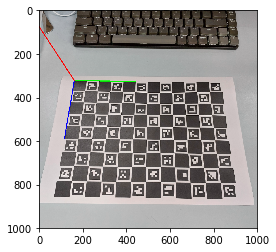

(True, array([[ 2.12466226],
       [ 2.1808066 ],
       [-0.21990116]]), array([[-0.11047503],
       [-0.07249176],
       [ 0.33535205]]))


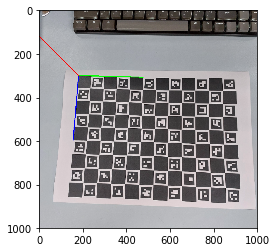

(True, array([[ 2.08626456],
       [ 2.15516046],
       [-0.58618399]]), array([[-0.1329366 ],
       [-0.07353368],
       [ 0.36072608]]))


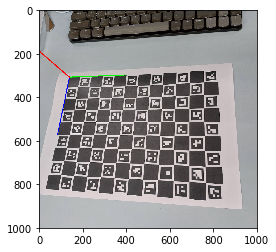

(True, array([[ 1.58939209],
       [ 2.50607299],
       [-0.71391639]]), array([[-0.09625281],
       [-0.10144797],
       [ 0.40284628]]))


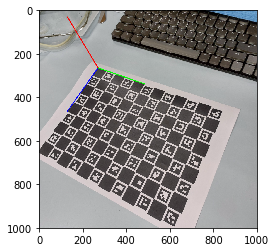

(True, array([[-1.58954742],
       [-2.49081218],
       [ 0.38736424]]), array([[-0.11759354],
       [-0.11869986],
       [ 0.39433348]]))


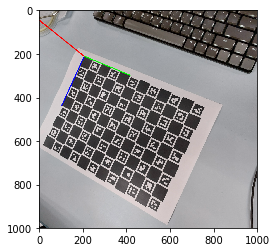

(True, array([[-1.70070408],
       [-2.48448578],
       [ 0.07312367]]), array([[-0.11850158],
       [-0.10890723],
       [ 0.36066724]]))


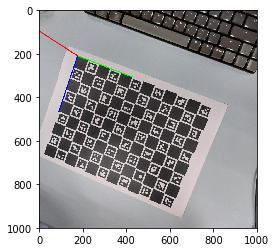

(True, array([[-1.99154591],
       [-2.36976587],
       [-0.06725852]]), array([[-0.09917829],
       [-0.07969211],
       [ 0.35480093]]))


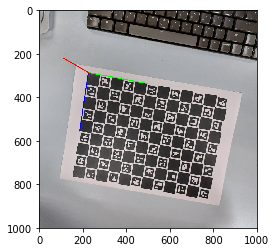

(True, array([[ 1.88207572],
       [ 2.19145363],
       [-0.03774838]]), array([[-0.08987177],
       [-0.10305058],
       [ 0.3616034 ]]))


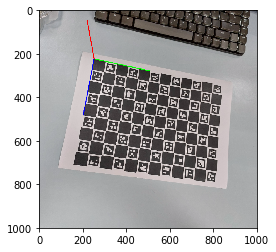

(True, array([[ 1.77333481],
       [ 2.21143073],
       [-0.39623319]]), array([[-0.10024462],
       [-0.1268914 ],
       [ 0.40597985]]))


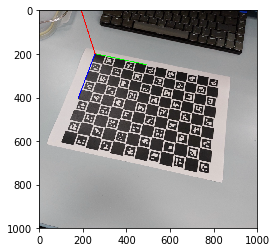

(True, array([[ 0.96736783],
       [ 2.66180241],
       [-0.42457496]]), array([[-0.03177911],
       [-0.15192161],
       [ 0.41728351]]))


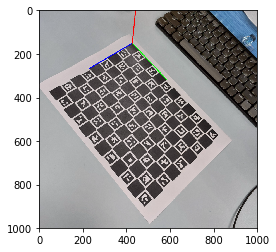

(True, array([[ 0.40459373],
       [ 2.84211317],
       [-0.36268759]]), array([[ 0.01961015],
       [-0.17422366],
       [ 0.39291296]]))


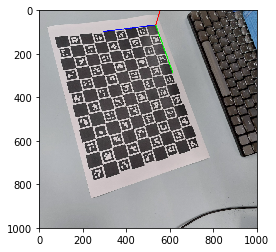

(True, array([[-0.72211966],
       [ 2.80266556],
       [-0.34713517]]), array([[ 0.11601318],
       [-0.08579355],
       [ 0.39151725]]))


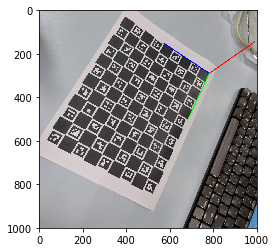

(True, array([[-1.41805747],
       [ 2.65444443],
       [-0.22577956]]), array([[ 0.15519006],
       [-0.01439505],
       [ 0.39476534]]))


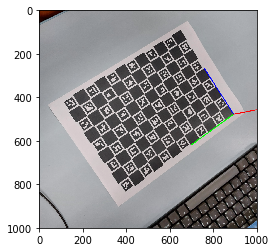

(True, array([[-1.99598948],
       [ 2.41244377],
       [-0.12184683]]), array([[0.14154532],
       [0.06283883],
       [0.35898131]]))


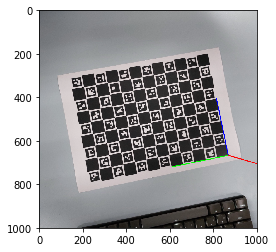

(True, array([[-2.76753863],
       [ 1.44856547],
       [ 0.10902053]]), array([[0.04969204],
       [0.1141754 ],
       [0.34818852]]))


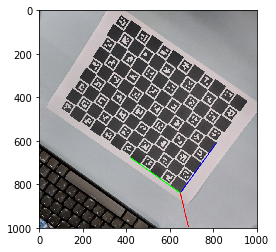

(True, array([[ 2.94148243],
       [-1.00342521],
       [-0.14267051]]), array([[-0.01087139],
       [ 0.13159281],
       [ 0.34668865]]))


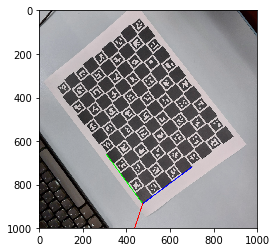

(True, array([[ 3.04185576],
       [-0.48814648],
       [-0.22363565]]), array([[-0.02971334],
       [ 0.13534511],
       [ 0.339838  ]]))


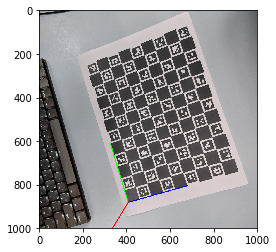

(True, array([[ 3.03923216],
       [ 0.1199724 ],
       [-0.32870434]]), array([[-0.06855423],
       [ 0.09512708],
       [ 0.34469298]]))


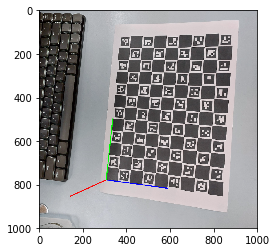

(True, array([[ 2.92921105],
       [ 0.57509536],
       [-0.38158319]]), array([[-0.10690884],
       [ 0.06018706],
       [ 0.35286028]]))


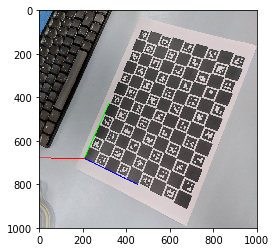

(True, array([[ 2.83056531],
       [ 0.89480517],
       [-0.46092922]]), array([[-0.1319182 ],
       [ 0.02752071],
       [ 0.37820411]]))


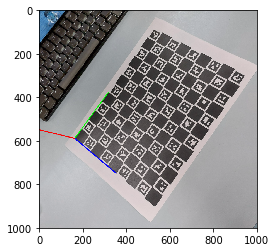

20


In [22]:
# original 
# charucoPose=[]
for i, image in enumerate(images):
    # print(os.path.basename(image))
    #ret2,rvec2,tvec2=aruco.estimatePoseCharucoBoard(allCorners,allIds, board,mtx,dist,rvecs,tvecs)
    ret2, rvec2, tvec2 = aruco.estimatePoseCharucoBoard(corners_all[i], ids_all[i], CHARUCO_BOARD, cameraMatrix, distCoeffs, rvecs[i], tvecs[i])
    print(ret2, rvec2, tvec2)
    img0 = cv2.imread(images[i])
    imgNew = aruco.drawAxis(img0, cameraMatrix, distCoeffs, rvec2, tvec2, 0.1)
    # Reproportion the image, maxing width or height at 1000
    proportion = max(imgNew.shape) / 1000.0
    imgNew = cv2.resize(imgNew, (int(imgNew.shape[1]/proportion), int(imgNew.shape[0]/proportion)))
    plt.imshow(imgNew)
    plt.show()
    # # # cv2.imshow('Charuco board Axis', imgNew)
    # # #cv2.waitKey(0)
    # Euler = AngleAxis2EulerZYX(rvec2);
    # # print(Euler)
    # tx = (CHARUCO_BOARD.getChessboardSize()[0]) * (CHARUCO_BOARD.getSquareLength())/2
    # ty = (CHARUCO_BOARD.getChessboardSize()[1]) * (CHARUCO_BOARD.getSquareLength())/2
    # # TransO = (Mat_<double>(3,1) <<tx,ty,0);
    # TransO = np.array([tx,ty,0])
    # # print(TransO)

    # R=cv2.Rodrigues(rvec2)
    # Trans_tvec = R[0].dot(TransO)
    # CharucoPose=[0,0,0,0,0,0]
    # for j in range(3):
    #     tvec2[j]+=Trans_tvec[j]
    # #     tvec[i]=tvec[i]+Trans_tvec.at<double>(i,0)
    #     CharucoPose[j]  = tvec2[j][0]*1000
    #     CharucoPose[j+3]= Euler[j]*180/math.pi
    # img01 = cv2.imread(images[i])
    # imgNew=aruco.drawAxis(img01,cameraMatrix,distCoeffs,rvec2,tvec2,0.1)
    # # print(ret2, rvec2, tvec2)
    # # Reproportion the image, maxing width or height at 1000
    # proportion = max(imgNew.shape) / 1000.0
    # imgNew = cv2.resize(imgNew, (int(imgNew.shape[1]/proportion), int(imgNew.shape[0]/proportion)))
    # # print("imgs:",images[i])
    # print("charucoPose:",CharucoPose)
    # save_img("0719_"+str(i)+".jpg", imgNew)
    
    #saveCamP(CharucoPose,"./pic_highres")
    # cv2.imshow('Charuco board Axis'+str(i), imgNew)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # plt.imshow(imgNew)
    # plt.show()
print(len(images))

In [7]:
images = glob.glob('picture/0720_test/*.jpg')
print(len(images))

28


20230720_143851.jpg
(True, array([[ 1.39921753],
       [ 2.2824749 ],
       [-0.78108034]]), array([[-0.06719839],
       [-0.10701759],
       [ 0.39896567]]))
[-2.809728320559677, 0.5885382480803771, 2.1431309216482433]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_143851.jpg')
('charucoPose:', [-0.6135644601769075, -0.8894303322514036, 316.48371734835894, -160.98557434645033, 33.720757697029036, 122.79235675442665])


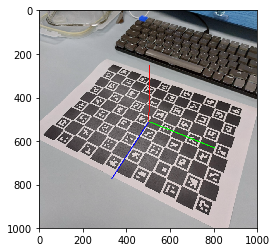

20230720_143856.jpg
(True, array([[ 2.10303545],
       [ 1.37807658],
       [-0.47934007]]), array([[-0.1416597 ],
       [-0.02377678],
       [ 0.36451303]]))
[2.8087091688187034, 0.616697466539581, 1.0532417019341638]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_143856.jpg')
('charucoPose:', [4.445232207165223, 3.6252448490181366, 344.45121784369985, 160.92718125300914, 35.3341620691283, 60.34630432800342])


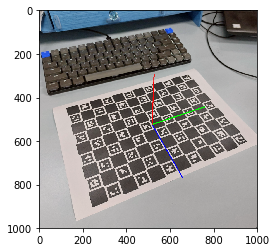

20230720_143858.jpg
(True, array([[ 2.40413565],
       [ 0.92089845],
       [-0.47892212]]), array([[-0.1310861 ],
       [ 0.01163093],
       [ 0.35380781]]))
[2.7430753397005327, 0.5109573651069789, 0.6262254753645463]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_143858.jpg')
('charucoPose:', [15.792206678549247, -18.622217175764185, 350.4153588070887, 157.1666398512551, 29.275700531754964, 35.880076761962215])


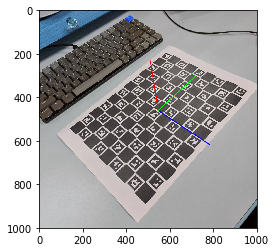

20230720_143901.jpg
(True, array([[ 2.5950851 ],
       [ 0.35132418],
       [-0.43850944]]), array([[-0.07969979],
       [ 0.07102753],
       [ 0.31314107]]))
[2.678575060676142, 0.37465177827496265, 0.17981792256388865]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_143901.jpg')
('charucoPose:', [41.20702720807, -16.118404116980734, 330.0858878339472, 153.47104608574134, 21.465965682226468, 10.302808043721075])


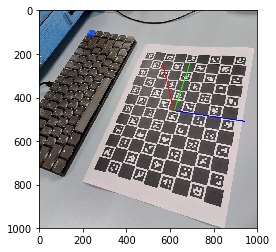

20230720_143906.jpg
(True, array([[ 1.87422851],
       [ 1.93576921],
       [-0.65952356]]), array([[-0.12349638],
       [-0.03195964],
       [ 0.50202806]]))
[-3.0473072403398564, 0.5960090231345656, 1.63207768198825]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_143906.jpg')
('charucoPose:', [-8.426766798591348, 43.36961012571724, 442.1574812434309, -174.59784375113176, 34.14880157732565, 93.51116301542126])


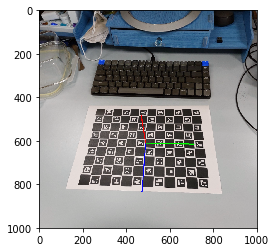

20230720_143912.jpg
(True, array([[ 1.6176883 ],
       [ 1.74009095],
       [-0.90311511]]), array([[-0.10811133],
       [-0.05154485],
       [ 0.40372783]]))
[-3.0001075413295397, 0.926082693903135, 1.714394907373625]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_143912.jpg')
('charucoPose:', [3.66213507151085, 5.601018877875244, 321.62397469995943, -171.8935002035528, 53.06062984075533, 98.22759261123042])


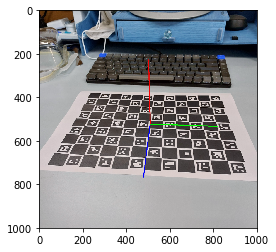

20230720_143914.jpg
(True, array([[ 1.3020021 ],
       [ 2.05145562],
       [-1.03716942]]), array([[-0.08116206],
       [-0.07563892],
       [ 0.44804319]]))
[-2.6223278501938196, 0.8262713882732099, 2.242383307451722]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_143914.jpg')
('charucoPose:', [-10.302674245847923, 2.6455689239988227, 341.5045287996428, -150.24831831572024, 47.34186328047027, 128.47909956757016])


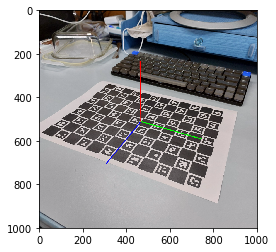

20230720_143921.jpg
(True, array([[-0.56048789],
       [ 2.56292183],
       [-0.97168806]]), array([[ 0.08851265],
       [-0.09690795],
       [ 0.44914566]]))
[-2.371959859469033, 0.1746975835221639, -2.640085152507846]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_143921.jpg')
('charucoPose:', [-17.907591386889465, -56.97149335254411, 351.26915866318524, -135.90328912201946, 10.009434226954188, -151.26573679385186])


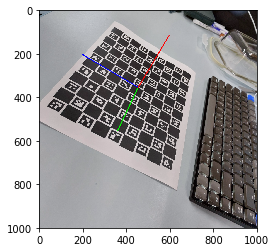

20230720_143927.jpg
(True, array([[ 2.40617415],
       [ 0.53331902],
       [-0.71207947]]), array([[-0.1259715 ],
       [ 0.04324892],
       [ 0.32958024]]))
[2.615193060862667, 0.6334473751334974, 0.26006789233908195]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_143927.jpg')
('charucoPose:', [5.296208550295667, -29.186499001997475, 324.9007408367793, 149.83952499933025, 36.29386113878961, 14.900792617892073])


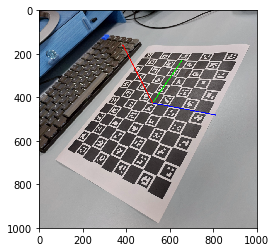

20230720_143932.jpg
(True, array([[ 2.32329497],
       [ 0.8444658 ],
       [-0.66544935]]), array([[-0.12337551],
       [ 0.02447167],
       [ 0.39730773]]))
[2.694522535819607, 0.6614194149242028, 0.5414815723047046]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_143932.jpg')
('charucoPose:', [20.56316321045351, -15.22654786156036, 382.96521039269686, 154.38476910535167, 37.89654096316903, 31.0246087771675])


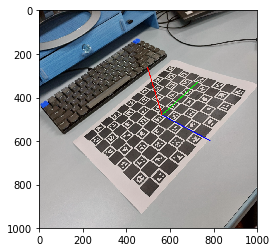

20230720_144001.jpg
(True, array([[ 1.58385231],
       [ 1.95399834],
       [-0.81481477]]), array([[-0.09596993],
       [-0.07685515],
       [ 0.40105338]]))
[-2.941605636133042, 0.7748353074096046, 1.8611168632544035]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144001.jpg')
('charucoPose:', [3.0819838156441874, 2.4487662844377285, 321.055841864234, -168.541587942319, 44.39479293229207, 106.6341414451037])


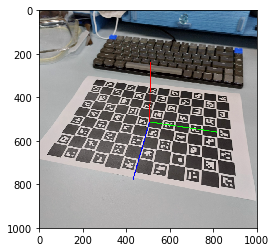

20230720_144003.jpg
(True, array([[ 1.39116464],
       [ 2.10892264],
       [-0.93419991]]), array([[-0.06736736],
       [-0.0792423 ],
       [ 0.43779326]]))
[-2.731302106127114, 0.7473252195726738, 2.1381278321962047]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144003.jpg')
('charucoPose:', [7.440868138208378, 8.129136363261875, 341.51263720298357, -156.49208325627652, 42.81858100520176, 122.50570084429842])


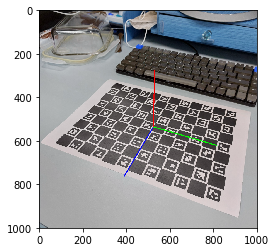

20230720_144006.jpg
(True, array([[ 0.95276802],
       [ 2.33928301],
       [-0.95174569]]), array([[-0.05627291],
       [-0.1056086 ],
       [ 0.45821681]]))
[-2.5683263147265505, 0.6534538407865138, 2.5671460201022183]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144006.jpg')
('charucoPose:', [-28.26508133207597, -3.645356948417444, 351.82575012137875, -147.1542582462197, 37.4401471836809, 147.0866323456635])


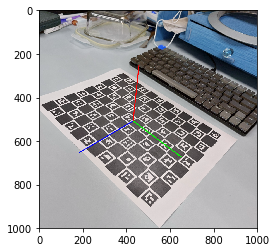

20230720_144009.jpg
(True, array([[ 0.72108392],
       [ 2.44897737],
       [-0.92723023]]), array([[-0.01776047],
       [-0.13886019],
       [ 0.45119649]]))
[-2.533908907250369, 0.5768135509988876, 2.7544048417638303]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144009.jpg')
('charucoPose:', [-15.816356767596432, -33.260471376739474, 344.68396279101654, -145.1822860560525, 33.04898203819033, 157.81577250346683])


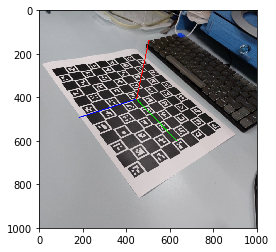

20230720_144011.jpg
(True, array([[ 0.56567   ],
       [ 2.50732586],
       [-0.5678653 ]]), array([[-0.01396713],
       [-0.12499317],
       [ 0.45042708]]))
[-2.799208389337809, 0.5838263508093247, 2.801617924059233]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144011.jpg')
('charucoPose:', [-26.131957088037403, -0.7929938574374462, 367.20250151898705, -160.3828266866694, 33.45078586989852, 160.52088285679721])


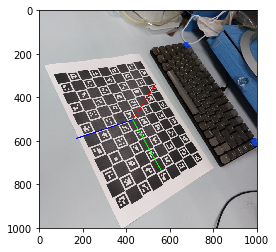

20230720_144014.jpg
(True, array([[ 2.14328628],
       [ 1.49781008],
       [-0.7029739 ]]), array([[-0.13243029],
       [-0.01131472],
       [ 0.40002038]]))
[3.066101465897864, 0.6745808677610436, 1.1934063367737326]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144014.jpg')
('charucoPose:', [6.790985844908615, 15.187621063231935, 350.87710703018666, 175.67467355482253, 38.650636662980496, 68.37714634130306])


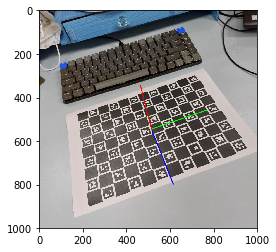

20230720_144021.jpg
(True, array([[ 1.50255967],
       [ 1.94462024],
       [-0.76030135]]), array([[-0.11577139],
       [-0.06037954],
       [ 0.43239427]]))
[-3.0004296612941492, 0.8117242846427445, 1.8866236342526392]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144021.jpg')
('charucoPose:', [-18.27629793646697, 23.758106815469713, 355.4815780957917, -171.91195631802185, 46.50837563830516, 108.09557177230928])


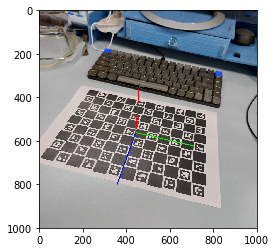

20230720_144024.jpg
(True, array([[ 1.03099652],
       [ 2.27803188],
       [-0.7147115 ]]), array([[-0.05765451],
       [-0.11165029],
       [ 0.45131241]]))
[-2.814882451539261, 0.7121244794931268, 2.414041643924398]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144024.jpg')
('charucoPose:', [-14.155594374619044, 1.7979539650478382, 363.3502621273159, -161.28088429863814, 40.80172716290671, 138.3143977656911])


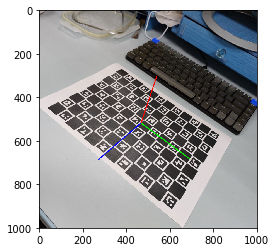

20230720_144026.jpg
(True, array([[ 0.50556863],
       [ 2.48753463],
       [-0.5277291 ]]), array([[-0.00373002],
       [-0.14720161],
       [ 0.44589623]]))
[-2.8182436120488874, 0.6115829777452034, 2.8434601459520934]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144026.jpg')
('charucoPose:', [-19.81778115950317, -23.22589943194747, 363.00349164805016, -161.47346461010576, 35.04112344684351, 162.91826557670802])


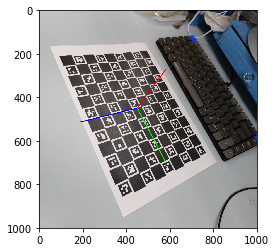

20230720_144029.jpg
(True, array([[ 1.37315062],
       [ 1.85071899],
       [-0.39863284]]), array([[-0.06280807],
       [-0.0670921 ],
       [ 0.43039821]]))
[2.8499099018298675, 0.8313589611836754, 1.735439293057579]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144029.jpg')
('charucoPose:', [36.44997694966454, 36.72468383571535, 387.15570427570884, 163.28780936739417, 47.63335973620503, 99.4333470933665])


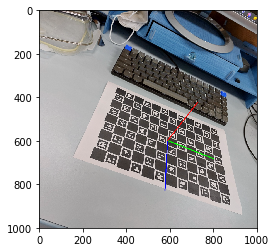

20230720_144705.jpg
(True, array([[ 1.77326515],
       [ 2.08205977],
       [-0.61093991]]), array([[-0.06065437],
       [-0.09111192],
       [ 0.35621472]]))
[-3.019813365969985, 0.5414285459619523, 1.7644819867055563]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144705.jpg')
('charucoPose:', [42.8304386752069, 0.12752935081543348, 297.3397918849033, -173.02256078727524, 31.021570591524778, 101.09737086508702])


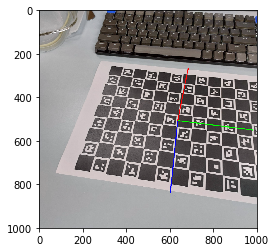

20230720_144708.jpg
(True, array([[ 1.87433936],
       [ 1.90438748],
       [-0.45799435]]), array([[-0.17282637],
       [-0.09029387],
       [ 0.34810637]]))
[3.0690653205024043, 0.542344623797525, 1.5665275712447353]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144708.jpg')
('charucoPose:', [-52.79472005824136, -9.232218748213421, 309.1010972289378, 175.84448991475307, 31.074057985208572, 89.7554183232027])


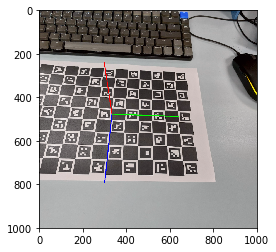

20230720_144714.jpg
(True, array([[ 1.66315978],
       [ 2.26936572],
       [-0.62276891]]), array([[0.03774568],
       [0.03337564],
       [0.39394662]]))
[-2.931671848111592, 0.46416662773596656, 1.9264779493353725]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144714.jpg')
('charucoPose:', [123.63900510671003, 139.1923224699196, 331.29548005550146, -167.97242381411235, 26.5947887600909, 110.37905582193449])


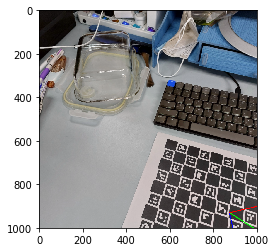

20230720_144718.jpg
(True, array([[ 2.09749541],
       [ 1.64448864],
       [-0.54246453]]), array([[-0.24564861],
       [ 0.0665514 ],
       [ 0.3694606 ]]))
[3.040303923407995, 0.5723034430872679, 1.3000225489565305]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144718.jpg')
('charucoPose:', [-108.61879416542693, 113.8528838496854, 330.9197262370447, 174.19658324834361, 32.79057188970596, 74.48580532704864])


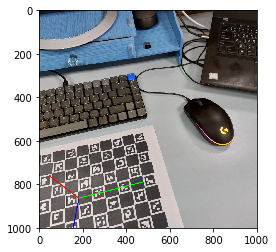

20230720_144726.jpg
(True, array([[-0.09874914],
       [ 2.76938786],
       [-0.1998551 ]]), array([[0.13563992],
       [0.03227527],
       [0.35372099]]))
[-2.9793602610110694, 0.35673804328603015, -3.0409977847310374]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144726.jpg')
('charucoPose:', [46.57434467374921, 142.3114026453331, 304.1289409825864, -170.70476860492963, 20.4395842720448, -174.23633857372133])


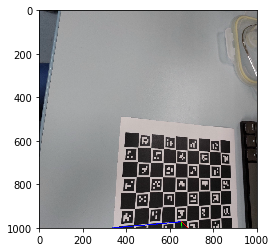

20230720_144729.jpg
(True, array([[ 2.09439906],
       [ 1.90606059],
       [-1.01209389]]), array([[0.06012243],
       [0.08525942],
       [0.43546782]]))
[-2.7329735303351694, 0.5841713765350721, 1.6011510405502631]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144729.jpg')
('charucoPose:', [168.71170867447006, 137.35782615865247, 346.05795588496153, -156.58784880917406, 33.47055438780728, 91.73919698651021])


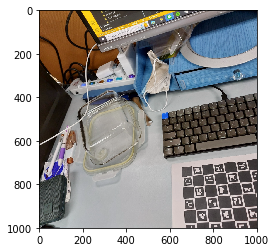

20230720_144732.jpg
(True, array([[ 2.26396834],
       [ 1.52612118],
       [-0.6327964 ]]), array([[-0.21633396],
       [ 0.12209268],
       [ 0.38849906]]))
[3.1064644266769212, 0.5650104746897193, 1.1760525733069322]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144732.jpg')
('charucoPose:', [-75.53083095051535, 148.22230811419251, 343.87035851454385, 177.9873008561146, 32.37271558040414, 67.38284893598708])


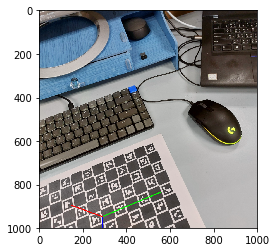

20230720_144735.jpg
(True, array([[ 2.32523734],
       [ 1.7199745 ],
       [-0.40835703]]), array([[-0.22225189],
       [-0.06404889],
       [ 0.28739674]]))
[3.129221576213816, 0.356263394488585, 1.271523609383105]
[0.09 0.12 0.  ]
('imgs:', 'picture/0720_test/20230720_144735.jpg')
('charucoPose:', [-82.57377720088016, -18.33108328739015, 257.39829466884646, 179.29118947832674, 20.412388899200234, 72.852936368893])


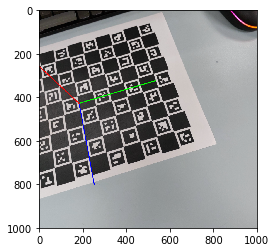

In [8]:
# change



for i, image in enumerate(images):
    print(os.path.basename(image))
    img0 = cv2.imread(image)
    
    # Grayscale the image
    gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)

    # Find aruco markers in the query image
    corners, ids, _ = aruco.detectMarkers(
            image=gray,
            dictionary=ARUCO_DICT)
    
    if len(corners) > 10:
    # Outline the aruco markers found in our query image
        img = aruco.drawDetectedMarkers(
                image=img0, 
                corners=corners)
        
        # Get charuco corners and ids from detected aruco markers
        response, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
                markerCorners=corners,
                markerIds=ids,
                image=gray,
                board=CHARUCO_BOARD)
    
    
    #ret2,rvec2,tvec2=aruco.estimatePoseCharucoBoard(allCorners,allIds, board,mtx,dist,rvecs,tvecs)
    ret2, rvec2, tvec2 = aruco.estimatePoseCharucoBoard(charuco_corners, charuco_ids, CHARUCO_BOARD, cameraMatrix, distCoeffs)
    print(ret2, rvec2, tvec2)
    imgNew = aruco.drawAxis(img0, cameraMatrix, distCoeffs, rvec2, tvec2, 0.1)
    # Reproportion the image, maxing width or height at 1000
    proportion = max(imgNew.shape) / 1000.0
    imgNew = cv2.resize(imgNew, (int(imgNew.shape[1]/proportion), int(imgNew.shape[0]/proportion)))
    # plt.imshow(imgNew)
    # plt.show()
    # # cv2.imshow('Charuco board Axis', imgNew)
    # #cv2.waitKey(0)
    Euler = AngleAxis2EulerZYX(rvec2);
    print(Euler)
    tx = (CHARUCO_BOARD.getChessboardSize()[0]) * (CHARUCO_BOARD.getSquareLength())/2
    ty = (CHARUCO_BOARD.getChessboardSize()[1]) * (CHARUCO_BOARD.getSquareLength())/2
    # TransO = (Mat_<double>(3,1) <<tx,ty,0);
    TransO = np.array([tx,ty,0])
    print(TransO)

    R=cv2.Rodrigues(rvec2)
    Trans_tvec = R[0].dot(TransO)
    CharucoPose=[0,0,0,0,0,0]
    for j in range(3):
        tvec2[j]+=Trans_tvec[j]
    #     tvec[i]=tvec[i]+Trans_tvec.at<double>(i,0)
        CharucoPose[j]  = tvec2[j][0]*1000
        CharucoPose[j+3]= Euler[j]*180/math.pi
    img01 = cv2.imread(images[i])
    imgNew=aruco.drawAxis(img01,cameraMatrix,distCoeffs,rvec2,tvec2,0.1)
    # Reproportion the image, maxing width or height at 1000
    proportion = max(imgNew.shape) / 1000.0
    imgNew = cv2.resize(imgNew, (int(imgNew.shape[1]/proportion), int(imgNew.shape[0]/proportion)))
    print("imgs:",images[i])
    print("charucoPose:",CharucoPose)
    save_img("0719_mp4_"+str(i)+".jpg", imgNew)
    
    #saveCamP(CharucoPose,"./pic_highres")
    # cv2.imshow('Charuco board Axis'+str(i), imgNew)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    plt.imshow(imgNew)
    plt.show()
